<a href="https://colab.research.google.com/github/achaudhury7378/IE-643-Implementation/blob/main/Project_Implementation_Task1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing The Libraries

In [ ]:
import argparse
import copy
import os
import sys
import numpy as np
from tqdm import tqdm
import torch
import torch.nn as nn
from torch.utils.data import random_split,ConcatDataset
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
import os
from torch.utils.tensorboard import SummaryWriter
import torchvision.utils as vutils
import seaborn as sns
import torch.nn.init as init
import pickle

# Custom Libraries
# import utils

In [ ]:
#ANCHOR Print table of zeros and non-zeros count
def print_nonzeros(model):
    nonzero = total = 0
    for name, p in model.named_parameters():
        tensor = p.data.cpu().numpy()
        nz_count = np.count_nonzero(tensor)
        total_params = np.prod(tensor.shape)
        nonzero += nz_count
        total += total_params
        print(f'{name:20} | nonzeros = {nz_count:7} / {total_params:7} ({100 * nz_count / total_params:6.2f}%) | total_pruned = {total_params - nz_count :7} | shape = {tensor.shape}')
    print(f'alive: {nonzero}, pruned : {total - nonzero}, total: {total}, Compression rate : {total/nonzero:10.2f}x  ({100 * (total-nonzero) / total:6.2f}% pruned)')
    return (round((nonzero/total)*100,1))

def original_initialization(mask_temp, initial_state_dict):
    global model
    
    step = 0
    for name, param in model.named_parameters(): 
        if "weight" in name: 
            weight_dev = param.device
            param.data = torch.from_numpy(mask_temp[step] * initial_state_dict[name].cpu().numpy()).to(weight_dev)
            step = step + 1
        if "bias" in name:
            param.data = initial_state_dict[name]
    step = 0

        


#ANCHOR Checks of the directory exist and if not, creates a new directory
def checkdir(directory):
            if not os.path.exists(directory):
                os.makedirs(directory)

#FIXME 
def plot_train_test_stats(stats,
                          epoch_num,
                          key1='train',
                          key2='test',
                          key1_label=None,
                          key2_label=None,
                          xlabel=None,
                          ylabel=None,
                          title=None,
                          yscale=None,
                          ylim_bottom=None,
                          ylim_top=None,
                          savefig=None,
                          sns_style='darkgrid'
                          ):

    assert len(stats[key1]) == epoch_num, "len(stats['{}'])({}) != epoch_num({})".format(key1, len(stats[key1]), epoch_num)
    assert len(stats[key2]) == epoch_num, "len(stats['{}'])({}) != epoch_num({})".format(key2, len(stats[key2]), epoch_num)

    plt.clf()
    sns.set_style(sns_style)
    x_ticks = np.arange(epoch_num)

    plt.plot(x_ticks, stats[key1], label=key1_label)
    plt.plot(x_ticks, stats[key2], label=key2_label)

    if xlabel is not None:
        plt.xlabel(xlabel)
    if ylabel is not None:
        plt.ylabel(ylabel)

    if title is not None:
        plt.title(title)

    if yscale is not None:
        plt.yscale(yscale)

    if ylim_bottom is not None:
        plt.ylim(bottom=ylim_bottom)
    if ylim_top is not None:
        plt.ylim(top=ylim_top)

    plt.legend(bbox_to_anchor=(1.04,0.5), loc="center left", borderaxespad=0, fancybox=True)

    if savefig is not None:
        plt.savefig(savefig, bbox_inches='tight')
    else:
        plt.show()

# Describing the Architectures

In [ ]:
class fc1(nn.Module):

    def __init__(self, num_classes=10):
        super(fc1, self).__init__()
        self.classifier = nn.Sequential(
            nn.Linear(28*28, 300),
            nn.ReLU(inplace=True),
            nn.Linear(300, 100),
            nn.ReLU(inplace=True),
            nn.Linear(100, num_classes),
        )

    def forward(self, x):
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x
class LeNet5(nn.Module):
    def __init__(self, num_classes=10):
        super(LeNet5, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=(3, 3), stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=(3, 3), stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )
        self.classifier = nn.Sequential(
            nn.Linear(64*14*14, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [ ]:
transform=transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.1307,), (0.3081,))])

In [ ]:
def my_split(traindataset):
  idx=(traindataset.targets==0)
  traindataset.targets = traindataset.targets[idx]
  traindataset.data = traindataset.data[idx]
  p=int((len(traindataset)-1)/2)
  dat1,dat2=random_split(traindataset, [p,len(traindataset)-p], generator=torch.Generator().manual_seed(42))
  for i in range(1,10):
    traindataset = datasets.MNIST('../data', train=True, download=True,transform=transform)
    idx=(traindataset.targets==i)
    traindataset.targets = traindataset.targets[idx]
    traindataset.data = traindataset.data[idx]
    if len(traindataset)%2==0:
      p=int(len(traindataset)/2)
    else:
      p=int((len(traindataset)-1)/2)
    dat1_2,dat2_2=random_split(traindataset, [p,len(traindataset)-p], generator=torch.Generator().manual_seed(42))
    dat1=ConcatDataset([dat1,dat1_2])
    dat2=ConcatDataset([dat2,dat2_2])
  return dat1,dat2

In [ ]:
v1,v2=my_split(traindataset)
# v1.targets

In [ ]:
train_loader = torch.utils.data.DataLoader(v1, batch_size=60, shuffle=True, num_workers=0,drop_last=False)

In [ ]:
train_loader_1 = torch.utils.data.DataLoader(v2, batch_size=60, shuffle=True, num_workers=0,drop_last=False)

In [ ]:
train_loader.shape

# The Main Procedures

In [ ]:
# Main
writer = SummaryWriter()
def main(args, ITE=0):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    reinit = True if args.prune_type=="reinit" else False

    # Data Loader
    transform=transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.1307,), (0.3081,))])
    if args.dataset == "mnist":
        traindataset = datasets.MNIST('../data', train=True, download=True,transform=transform)
        testdataset = datasets.MNIST('../data', train=False, transform=transform)
        # from archs.mnist import LeNet5, fc1
    # global v2
    # v1,v2=my_split(traindataset)
    train_loader = torch.utils.data.DataLoader(v2, batch_size=args.batch_size, shuffle=True, num_workers=0,drop_last=False)
    #train_loader = cycle(train_loader)
    test_loader = torch.utils.data.DataLoader(testdataset, batch_size=args.batch_size, shuffle=False, num_workers=0,drop_last=True)
    
    # Importing Network Architecture
    global model
    if args.arch_type == "fc1":
       model = fc1().to(device)
    elif args.arch_type == "lenet5":
        model = LeNet5().to(device)


    # Weight Initialization
    model.apply(weight_init)

    # Copying and Saving Initial State
    initial_state_dict = copy.deepcopy(model.state_dict())
    checkdir(f"{os.getcwd()}/saves/{args.arch_type}/{args.dataset}/")
    torch.save(model, f"{os.getcwd()}/saves/{args.arch_type}/{args.dataset}/initial_state_dict_{args.prune_type}.pth.tar")

    # Making Initial Mask
    make_mask(model)

    # Optimizer and Loss
    optimizer = torch.optim.Adam(model.parameters(), weight_decay=1e-4)
    criterion = nn.CrossEntropyLoss() # Default was F.nll_loss

    # Layer Looper
    for name, param in model.named_parameters():
        print(name, param.size())

    # Pruning
    # NOTE First Pruning Iteration is of No Compression
    bestacc = 0.0
    best_accuracy = 0
    ITERATION = args.prune_iterations
    comp = np.zeros(ITERATION,float)
    bestacc = np.zeros(ITERATION,float)
    step = 0
    all_loss = np.zeros(args.end_iter,float)
    all_accuracy = np.zeros(args.end_iter,float)


    for _ite in range(args.start_iter, ITERATION):
        if not _ite == 0:
            prune_by_percentile(args.prune_percent, resample=resample, reinit=reinit)
            if reinit:
                model.apply(weight_init)
                #if args.arch_type == "fc1":
                #    model = fc1.fc1().to(device)
                #elif args.arch_type == "lenet5":
                #    model = LeNet5.LeNet5().to(device)
                #elif args.arch_type == "alexnet":
                #    model = AlexNet.AlexNet().to(device)
                #elif args.arch_type == "vgg16":
                #    model = vgg.vgg16().to(device)  
                #elif args.arch_type == "resnet18":
                #    model = resnet.resnet18().to(device)   
                #elif args.arch_type == "densenet121":
                #    model = densenet.densenet121().to(device)   
                #else:
                #    print("\nWrong Model choice\n")
                #    exit()
                step = 0
                for name, param in model.named_parameters():
                    if 'weight' in name:
                        weight_dev = param.device
                        param.data = torch.from_numpy(param.data.cpu().numpy() * mask[step]).to(weight_dev)
                        step = step + 1
                step = 0
            else:
                original_initialization(mask, initial_state_dict)
            optimizer = torch.optim.Adam(model.parameters(), lr=args.lr, weight_decay=1e-4)
        print(f"\n--- Pruning Level [{ITE}:{_ite}/{ITERATION}]: ---")

        # Print the table of Nonzeros in each layer
        comp1 = print_nonzeros(model)
        comp[_ite] = comp1
        pbar = tqdm(range(args.end_iter))

        for iter_ in pbar:

            # Frequency for Testing
            if iter_ % args.valid_freq == 0:
                accuracy = test(model, test_loader, criterion)

                # Save Weights
                if accuracy > best_accuracy:
                    best_accuracy = accuracy
                    checkdir(f"{os.getcwd()}/saves/{args.arch_type}/{args.dataset}/")
                    torch.save(model,f"{os.getcwd()}/saves/{args.arch_type}/{args.dataset}/{_ite}_model_{args.prune_type}.pth.tar")

            # Training
            loss = train(model, train_loader, optimizer, criterion)
            all_loss[iter_] = loss
            all_accuracy[iter_] = accuracy
            
            # Frequency for Printing Accuracy and Loss
            if iter_ % args.print_freq == 0:
                pbar.set_description(
                    f'Train Epoch: {iter_}/{args.end_iter} Loss: {loss:.6f} Accuracy: {accuracy:.2f}% Best Accuracy: {best_accuracy:.2f}%')       

        writer.add_scalar('Accuracy/test', best_accuracy, comp1)
        bestacc[_ite]=best_accuracy

        # Plotting Loss (Training), Accuracy (Testing), Iteration Curve
        #NOTE Loss is computed for every iteration while Accuracy is computed only for every {args.valid_freq} iterations. Therefore Accuracy saved is constant during the uncomputed iterations.
        #NOTE Normalized the accuracy to [0,100] for ease of plotting.
        plt.plot(np.arange(1,(args.end_iter)+1), 100*(all_loss - np.min(all_loss))/np.ptp(all_loss).astype(float), c="blue", label="Loss") 
        plt.plot(np.arange(1,(args.end_iter)+1), all_accuracy, c="red", label="Accuracy") 
        Loss.append(100*(all_loss - np.min(all_loss))/np.ptp(all_loss))
        Accuracies.append(all_accuracy)
        Iters.append(args.end_iter)
        Comps.append(comp1)
        plt.title(f"Loss Vs Accuracy Vs Iterations ({args.dataset},{args.arch_type})") 
        plt.xlabel("Iterations") 
        plt.ylabel("Loss and Accuracy") 
        plt.legend() 
        plt.grid(color="gray") 
        checkdir(f"{os.getcwd()}/plots/lt/{args.arch_type}/{args.dataset}/")
        plt.savefig(f"{os.getcwd()}/plots/lt/{args.arch_type}/{args.dataset}/{args.prune_type}_LossVsAccuracy_{comp1}.png", dpi=1200) 
        plt.close()

        # Dump Plot values
        # utils.checkdir(f"{os.getcwd()}/dumps/lt/{args.arch_type}/{args.dataset}/")
        # all_loss.dump(f"{os.getcwd()}/dumps/lt/{args.arch_type}/{args.dataset}/{args.prune_type}_all_loss_{comp1}.dat")
        # all_accuracy.dump(f"{os.getcwd()}/dumps/lt/{args.arch_type}/{args.dataset}/{args.prune_type}_all_accuracy_{comp1}.dat")
        
        # Dumping mask
        # utils.checkdir(f"{os.getcwd()}/dumps/lt/{args.arch_type}/{args.dataset}/")
        # with open(f"{os.getcwd()}/dumps/lt/{args.arch_type}/{args.dataset}/{args.prune_type}_mask_{comp1}.pkl", 'wb') as fp:
        #     pickle.dump(mask, fp)
        
        # Making variables into 0
        best_accuracy = 0
        all_loss = np.zeros(args.end_iter,float)
        all_accuracy = np.zeros(args.end_iter,float)

    # Dumping Values for Plotting
    # utils.checkdir(f"{os.getcwd()}/dumps/lt/{args.arch_type}/{args.dataset}/")
    # comp.dump(f"{os.getcwd()}/dumps/lt/{args.arch_type}/{args.dataset}/{args.prune_type}_compression.dat")
    # bestacc.dump(f"{os.getcwd()}/dumps/lt/{args.arch_type}/{args.dataset}/{args.prune_type}_bestaccuracy.dat")

    # Plotting 
    a = np.arange(args.prune_iterations)
    plt.plot(a, bestacc, c="blue", label="Winning tickets") 
    plt.title(f"Test Accuracy vs Unpruned Weights Percentage ({args.dataset},{args.arch_type})") 
    plt.xlabel("Unpruned Weights Percentage") 
    plt.ylabel("test accuracy") 
    plt.xticks(a, comp, rotation ="vertical") 
    plt.ylim(0,100)
    plt.legend() 
    plt.grid(color="gray") 
    checkdir(f"{os.getcwd()}/plots/lt/{args.arch_type}/{args.dataset}/")
    plt.savefig(f"{os.getcwd()}/plots/lt/{args.arch_type}/{args.dataset}/{args.prune_type}_AccuracyVsWeights.png", dpi=1200) 
    plt.close() 
    return (a,comp,bestacc)                   
   
# Function for Training
def train(model, train_loader, optimizer, criterion):
    EPS = 1e-6
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.train()
    for batch_idx, (imgs, targets) in enumerate(train_loader):
        optimizer.zero_grad()
        #imgs, targets = next(train_loader)
        imgs, targets = imgs.to(device), targets.to(device)
        output = model(imgs)
        train_loss = criterion(output, targets)
        train_loss.backward()
        # print(imgs.shape)

        # Freezing Pruned weights by making their gradients Zero
        for name, p in model.named_parameters():
            if 'weight' in name:
                tensor = p.data.cpu().numpy()
                grad_tensor = p.grad.data.cpu().numpy()
                grad_tensor = np.where(tensor < EPS, 0, grad_tensor)
                p.grad.data = torch.from_numpy(grad_tensor).to(device)
        optimizer.step()
    return train_loss.item()

# Function for Testing
def test(model, test_loader, criterion):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    test_loss = 0
    correct = 0
    data_len=0
    with torch.no_grad():
        for data, target in test_loader:
          data, target = data.to(device), target.to(device)
          output = model(data)
          test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
          pred = output.data.max(1, keepdim=True)[1]  # get the index of the max log-probability
          correct += pred.eq(target.data.view_as(pred)).sum().item()
        test_loss /= len(test_loader.dataset)
        accuracy = 100. * correct /len(test_loader.dataset)
    return accuracy

# Prune by Percentile module
def prune_by_percentile(percent, resample=False, reinit=False,**kwargs):
        global step
        global mask
        global model

        # Calculate percentile value
        step = 0
        for name, param in model.named_parameters():

            # We do not prune bias term
            if 'weight' in name:
                tensor = param.data.cpu().numpy()
                alive = tensor[np.nonzero(tensor)] # flattened array of nonzero values
                percentile_value = np.percentile(abs(alive), percent)

                # Convert Tensors to numpy and calculate
                weight_dev = param.device
                new_mask = np.where(abs(tensor) < percentile_value, 0, mask[step])
                
                # Apply new weight and mask
                param.data = torch.from_numpy(tensor * new_mask).to(weight_dev)
                mask[step] = new_mask
                step += 1
        step = 0

# Function to make an empty mask of the same size as the model
def make_mask(model):
    global step
    global mask
    step = 0
    for name, param in model.named_parameters(): 
        if 'weight' in name:
            step = step + 1
    mask = [None]* step 
    step = 0
    for name, param in model.named_parameters(): 
        if 'weight' in name:
            tensor = param.data.cpu().numpy()
            mask[step] = np.ones_like(tensor)
            step = step + 1
    step = 0

# def original_initialization(mask_temp, initial_state_dict):
#     global model
    
#     step = 0
#     for name, param in model.named_parameters(): 
#         if "weight" in name: 
#             weight_dev = param.device
#             param.data = torch.from_numpy(mask_temp[step] * initial_state_dict[name].cpu().numpy()).to(weight_dev)
#             step = step + 1
#         if "bias" in name:
#             param.data = initial_state_dict[name]
#     step = 0

# Function for Initialization
def weight_init(m):
    '''
    Usage:
        model = Model()
        model.apply(weight_init)
    '''
    if isinstance(m, nn.Conv1d):
        init.normal_(m.weight.data)
        if m.bias is not None:
            init.normal_(m.bias.data)
    elif isinstance(m, nn.Conv2d):
        init.xavier_normal_(m.weight.data)
        if m.bias is not None:
            init.normal_(m.bias.data)
    elif isinstance(m, nn.Conv3d):
        init.xavier_normal_(m.weight.data)
        if m.bias is not None:
            init.normal_(m.bias.data)
    elif isinstance(m, nn.ConvTranspose1d):
        init.normal_(m.weight.data)
        if m.bias is not None:
            init.normal_(m.bias.data)
    elif isinstance(m, nn.ConvTranspose2d):
        init.xavier_normal_(m.weight.data)
        if m.bias is not None:
            init.normal_(m.bias.data)
    elif isinstance(m, nn.ConvTranspose3d):
        init.xavier_normal_(m.weight.data)
        if m.bias is not None:
            init.normal_(m.bias.data)
    elif isinstance(m, nn.BatchNorm1d):
        init.normal_(m.weight.data, mean=1, std=0.02)
        init.constant_(m.bias.data, 0)
    elif isinstance(m, nn.BatchNorm2d):
        init.normal_(m.weight.data, mean=1, std=0.02)
        init.constant_(m.bias.data, 0)
    elif isinstance(m, nn.BatchNorm3d):
        init.normal_(m.weight.data, mean=1, std=0.02)
        init.constant_(m.bias.data, 0)
    elif isinstance(m, nn.Linear):
        init.xavier_normal_(m.weight.data)
        init.normal_(m.bias.data)
    elif isinstance(m, nn.LSTM):
        for param in m.parameters():
            if len(param.shape) >= 2:
                init.orthogonal_(param.data)
            else:
                init.normal_(param.data)
    elif isinstance(m, nn.LSTMCell):
        for param in m.parameters():
            if len(param.shape) >= 2:
                init.orthogonal_(param.data)
            else:
                init.normal_(param.data)
    elif isinstance(m, nn.GRU):
        for param in m.parameters():
            if len(param.shape) >= 2:
                init.orthogonal_(param.data)
            else:
                init.normal_(param.data)
    elif isinstance(m, nn.GRUCell):
        for param in m.parameters():
            if len(param.shape) >= 2:
                init.orthogonal_(param.data)
            else:
                init.normal_(param.data)


if __name__=="__main__":
    
    #from gooey import Gooey
    #@Gooey      
    
    # Arguement Parser
    # parser = argparse.ArgumentParser()
    # parser.add_argument("--lr",default= 1.2e-3, type=float, help="Learning rate")
    # parser.add_argument("--batch_size", default=60, type=int)
    # parser.add_argument("--start_iter", default=0, type=int)
    # parser.add_argument("--end_iter", default=100, type=int)
    # parser.add_argument("--print_freq", default=1, type=int)
    # parser.add_argument("--valid_freq", default=1, type=int)
    # parser.add_argument("--resume", action="store_true")
    # parser.add_argument("--prune_type", default="lt", type=str, help="lt | reinit")
    # parser.add_argument("--gpu", default="0", type=str)
    # parser.add_argument("--dataset", default="mnist", type=str, help="mnist | cifar10 | fashionmnist | cifar100")
    # parser.add_argument("--arch_type", default="fc1", type=str, help="fc1 | lenet5 | alexnet | vgg16 | resnet18 | densenet121")
    # parser.add_argument("--prune_percent", default=10, type=int, help="Pruning percent")
    # parser.add_argument("--prune_iterations", default=35, type=int, help="Pruning iterations count")

    class data():
        def __init__(self,lr=1.2e-3,batch_size=70,start_iter=0,end_iter=50,print_freq=1,valid_freq=10,resume=True,prune_type="lt",gpu="0",dataset="mnist",arch_type="lenet5",prune_percent=20,prune_iterations=20):
          self.lr=lr
          self.batch_size=batch_size
          # self.transfer=transfer
          self.start_iter=start_iter
          self.end_iter=end_iter
          self.print_freq=print_freq
          self.valid_freq=valid_freq
          self.resume=resume
          self.prune_type=prune_type
          self.gpu=gpu
          self.dataset=dataset
          self.arch_type=arch_type
          self.prune_percent=prune_percent
          self.prune_iterations=prune_iterations

    args = data()


    os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
    os.environ["CUDA_VISIBLE_DEVICES"]=args.gpu
    
    
    #FIXME resample
    resample = False
    Loss=[]
    Accuracies=[]
    Iters=[]
    Comps=[]
    # Looping Entire process
    #for i in range(0, 5):
    (a,comp,best_acc)=main(args, ITE=1)

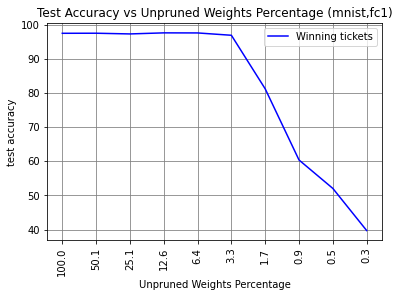

In [ ]:
plt.plot(a, best_acc, c="blue", label="Winning tickets") 
plt.title(f"Test Accuracy vs Unpruned Weights Percentage ({args.dataset},{args.arch_type})") 
plt.xlabel("Unpruned Weights Percentage") 
plt.ylabel("test accuracy") 
plt.xticks(a, comp, rotation ="vertical") 
# plt.ylim(0,100)
plt.legend() 
plt.grid(color="gray") 
# checkdir(f"{os.getcwd()}/plots/lt/{args.arch_type}/{args.dataset}/")
# plt.savefig(f"{os.getcwd()}/plots/lt/{args.arch_type}/{args.dataset}/{args.prune_type}_AccuracyVsWeights.png", dpi=1200) 
plt.show()
plt.close()

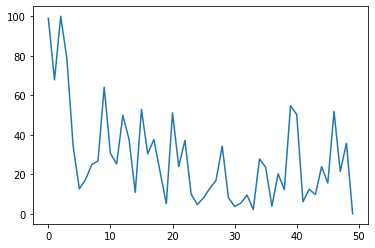

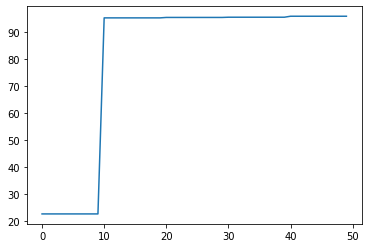

In [ ]:
#Plot Losses 
# levels=np.arange(1,(args.end_iter)+1)
# for i in range(len(Iters)):
#   levels=np.arange(1,(Iters[i])+1)
plt.plot(Loss[-1])
# plt.legend(Comps)
plt.show()
#Plot Accuracies
# for i in range(len(Iters)):
#   levels=np.arange(1,(Iters[i])+1)
plt.plot(Accuracies[-1])
# plt.legend(Comps)
plt.show()

In [ ]:
transform=transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.1307,), (0.3081,))])
# traindataset = datasets.MNIST('../data', train=True, download=True,transform=transform)
testdataset = datasets.MNIST('../data', train=False, transform=transform)
# train_loader = torch.utils.data.DataLoader(traindataset, batch_size=args.batch_size, shuffle=True, num_workers=0,drop_last=False)
test_loader = torch.utils.data.DataLoader(testdataset, batch_size=args.batch_size, shuffle=False, num_workers=0,drop_last=True)

In [ ]:
train_loader = torch.utils.data.DataLoader(v2, batch_size=args.batch_size, shuffle=True, num_workers=0,drop_last=False)

In [ ]:
initial_state_dict = copy.deepcopy(model.state_dict())

In [ ]:
original_initialization(mask, initial_state_dict)

In [ ]:
pbar = tqdm(range(args.end_iter))
all_loss = np.zeros(args.end_iter,float)
all_accuracy=np.zeros(args.end_iter,float)
optimizer = torch.optim.Adam(model.parameters(), weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()
for iter_ in pbar:
  loss = train(model, train_loader, optimizer, criterion)
  accuracy = test(model, test_loader, criterion)
  all_loss[iter_] = loss
  all_accuracy[iter_]=accuracy


100%|██████████| 50/50 [10:26<00:00, 12.53s/it]


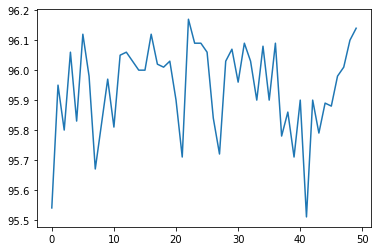

In [ ]:
plt.plot(all_accuracy)

In [ ]:
all_accuracy

array([95.54, 95.95, 95.8 , 96.06, 95.83, 96.12, 95.98, 95.67, 95.82,
       95.97, 95.81, 96.05, 96.06, 96.03, 96.  , 96.  , 96.12, 96.02,
       96.01, 96.03, 95.9 , 95.71, 96.17, 96.09, 96.09, 96.06, 95.84,
       95.72, 96.03, 96.07, 95.96, 96.09, 96.03, 95.9 , 96.08, 95.9 ,
       96.09, 95.78, 95.86, 95.71, 95.9 , 95.51, 95.9 , 95.79, 95.89,
       95.88, 95.98, 96.01, 96.1 , 96.14])

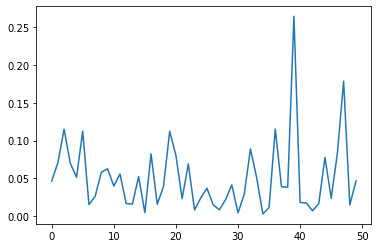

In [ ]:
plt.plot(all_loss)

In [ ]:
print_nonzeros(model)

classifier.0.weight  | nonzeros =   14701 /  235200 (  6.25%) | total_pruned =  220499 | shape = (300, 784)
classifier.0.bias    | nonzeros =     300 /     300 (100.00%) | total_pruned =       0 | shape = (300,)
classifier.2.weight  | nonzeros =    1875 /   30000 (  6.25%) | total_pruned =   28125 | shape = (100, 300)
classifier.2.bias    | nonzeros =     100 /     100 (100.00%) | total_pruned =       0 | shape = (100,)
classifier.4.weight  | nonzeros =      63 /    1000 (  6.30%) | total_pruned =     937 | shape = (10, 100)
classifier.4.bias    | nonzeros =      10 /      10 (100.00%) | total_pruned =       0 | shape = (10,)
alive: 17049, pruned : 249561, total: 266610, Compression rate :      15.64x  ( 93.61% pruned)


6.4

In [ ]:
print_nonzeros(model)

classifier.0.weight  | nonzeros =   14701 /  235200 (  6.25%) | total_pruned =  220499 | shape = (300, 784)
classifier.0.bias    | nonzeros =     300 /     300 (100.00%) | total_pruned =       0 | shape = (300,)
classifier.2.weight  | nonzeros =    1875 /   30000 (  6.25%) | total_pruned =   28125 | shape = (100, 300)
classifier.2.bias    | nonzeros =     100 /     100 (100.00%) | total_pruned =       0 | shape = (100,)
classifier.4.weight  | nonzeros =      63 /    1000 (  6.30%) | total_pruned =     937 | shape = (10, 100)
classifier.4.bias    | nonzeros =      10 /      10 (100.00%) | total_pruned =       0 | shape = (10,)
alive: 17049, pruned : 249561, total: 266610, Compression rate :      15.64x  ( 93.61% pruned)


6.4

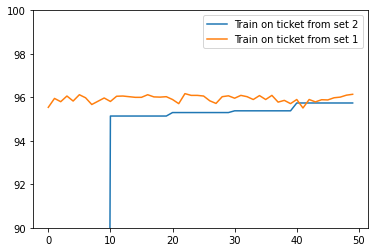

In [ ]:
plt.plot(Accuracies[-1])
plt.plot(all_accuracy)
plt.legend(['Train on ticket from set 2','Train on ticket from set 1'])
plt.ylim((90,100))
plt.show()

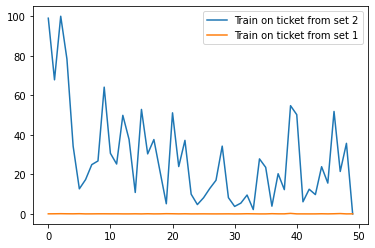

In [ ]:
plt.plot(Loss[-1])
plt.plot(all_loss)
plt.legend(['Train on ticket from set 2','Train on ticket from set 1'])
# plt.ylim((0,10))
plt.show()